<a href="https://colab.research.google.com/github/EdwynZN/TLGColab/blob/main/DS_C7_SC1_EDWIN_ZAMBRANO_NEMEGYEi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install heatmapz

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=1691f0423b525e63bd21f38bf4775b31230e6e75322bfc3fcfc9d96d993456d8
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from google.colab import drive
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("SC1") \
    .getOrCreate()

drive.mount('/content/gdrive')

Mounted at /content/gdrive


Cargamos el csv y seleccionamos las columnas relevantes (las que contienen datos númericos)

In [91]:
path_csv="/content/gdrive/My Drive/Colab Notebooks/PySpark/MonterreyPollutionData.csv"

df = spark.read.csv(path_csv,header=True,inferSchema=True)
df.createOrReplaceTempView("pollution")
df = df.withColumnRenamed('PM2.5',"PM2_5")
df = spark.sql("SELECT Month, Day, WeekDay, Hour, CO, NO, NO2, NOX, O3, PM10, PRS, `PM2.5` as PM2_5, RAINF, RH, SR, TOUT, WSR, WDV from pollution")
df.show(10)

+-----+---+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|Month|Day|WeekDay|Hour|  CO|  NO| NO2| NOX| O3|PM10|  PRS|PM2_5|RAINF| RH|   SR|TOUT|WSR|WDV|
+-----+---+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|    1|  1|      5|   1|2.51|10.2|12.9|23.1| 10| 139|725.4|   80| 0.01| 96|  0.0|3.91|7.2|344|
|    1|  1|      5|   2|2.41| 9.2|11.6|20.8|  7|  42|725.0|   29| 0.02| 96|  0.0|3.81|6.3|341|
|    1|  1|      5|   3|2.39| 8.1|11.8|19.9|  7|  23|724.4|    9|  0.0| 96|  0.0|3.85|5.2|346|
|    1|  1|      5|   5|2.26| 5.3| 8.9|14.2|  7|  23|724.0|   14| 0.01| 96|  0.0|3.79|5.6|336|
|    1|  1|      5|   8|2.25| 7.2|10.2|17.4|  5|  15|724.3|    8|  0.0| 96|0.023|3.93|4.8|354|
|    1|  1|      5|   9|2.21| 5.8| 8.2|14.0|  7|  16|724.3|    6|  0.0| 96|0.052|4.13|4.2| 15|
|    1|  1|      5|  12|2.38|10.0|10.1|20.1| 10|  22|722.6|   17|  0.0| 96|0.127| 6.6|3.2| 29|
|    1|  1|      5|  13|2.51|11.5|12.3|23.8| 12|  

In [4]:
df.printSchema()

root
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- WeekDay: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- CO: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NOX: double (nullable = true)
 |-- O3: integer (nullable = true)
 |-- PM10: integer (nullable = true)
 |-- PRS: double (nullable = true)
 |-- PM2_5: integer (nullable = true)
 |-- RAINF: double (nullable = true)
 |-- RH: integer (nullable = true)
 |-- SR: double (nullable = true)
 |-- TOUT: double (nullable = true)
 |-- WSR: double (nullable = true)
 |-- WDV: integer (nullable = true)



In [5]:
from pyspark.mllib.stat import Statistics
df_features = df.select(*df.columns).dropna()

rdd_table = df_features.rdd.map(lambda row: row[0:])

corr_mat = Statistics.corr(rdd_table, method="pearson")

corr_mat_df = pd.DataFrame(data=corr_mat,index=df_features.columns,columns=df_features.columns)
corr_mat_df

,Month,Day,WeekDay,Hour,CO,NO,NO2,NOX,O3,PM10,PRS,PM2_5,RAINF,RH,SR,TOUT,WSR,WDV
Month,1.000000,-0.066819,0.005771,0.005405,-0.548611,-0.313199,-0.591945,-0.453517,0.213890,-0.239885,-0.433587,-0.057530,-0.010824,-0.181146,0.160905,0.673499,0.264641,-0.221022
Day,-0.066819,1.000000,-0.005982,-0.001556,0.101612,0.038179,0.055925,0.049177,0.089457,0.077583,-0.036614,-0.013651,-0.023473,-0.209823,0.062363,0.110851,0.045269,0.028351
WeekDay,0.005771,-0.005982,1.000000,-0.008607,0.033262,-0.036192,-0.022819,-0.035333,0.015993,-0.018170,0.067625,0.016755,0.031300,0.077541,-0.010450,-0.069855,0.025171,-0.049517
Hour,0.005405,-0.001556,-0.008607,1.000000,0.063854,-0.068973,0.065701,-0.027028,0.228381,0.088958,-0.047857,0.097884,0.020795,-0.362518,0.048570,0.218742,0.424072,-0.128215
CO,-0.548611,0.101612,0.033262,0.063854,1.000000,0.597840,0.678066,0.696202,-0.196441,0.396805,0.251633,0.217616,0.010225,0.104443,-0.166540,-0.417004,-0.341591,0.232311
NO,-0.313199,0.038179,-0.036192,-0.068973,0.597840,1.000000,0.562418,0.952031,-0.275251,0.481058,0.175222,0.232708,-0.009182,0.068039,-0.103299,-0.291055,-0.343986,0.259888
NO2,-0.591945,0.055925,-0.022819,0.065701,0.678066,0.562418,1.000000,0.788449,-0.302997,0.550361,0.285011,0.302022,0.009580,0.009099,-0.200736,-0.443810,-0.488231,0.261746
NOX,-0.453517,0.049177,-0.035333,-0.027028,0.696202,0.952031,0.788449,1.000000,-0.316941,0.561353,0.236130,0.284654,-0.003227,0.054647,-0.151194,-0.381639,-0.436568,0.290354
O3,0.213890,0.089457,0.015993,0.228381,-0.196441,-0.275251,-0.302997,-0.316941,1.000000,-0.046893,-0.219732,-0.008811,-0.030142,-0.655588,0.691927,0.527154,0.466254,-0.198798
PM10,-0.239885,0.077583,-0.018170,0.088958,0.396805,0.481058,0.550361,0.561353,-0.046893,1.000000,-0.076597,0.511989,-0.025532,-0.103133,0.055220,0.059941,-0.139638,0.063298


###### Correlación de variables

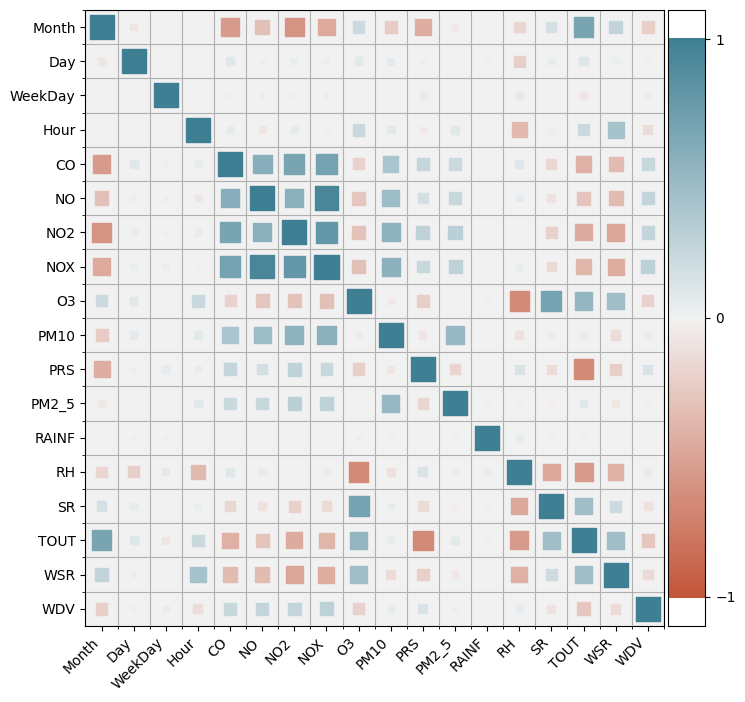

In [6]:
from heatmap import corrplot
plt.figure(figsize=(8, 8))
corrplot(corr_mat_df ,size_scale=300);

O3 se ve más afectado por SR (y en menor medida pero igual de importantes TOUT y WSR). De manera inversa O3 disminuye en medida que RH aumente (inversamente proporcional) lo que significa que a mayor humedad, menor concentración de ozono

Para PM2.5 esta directamente relacionado con PM10 lo cuál hace sentido porque todas las partículas menores a 2.5 um entran en la categoría de menores a 10um (pero no al réves)

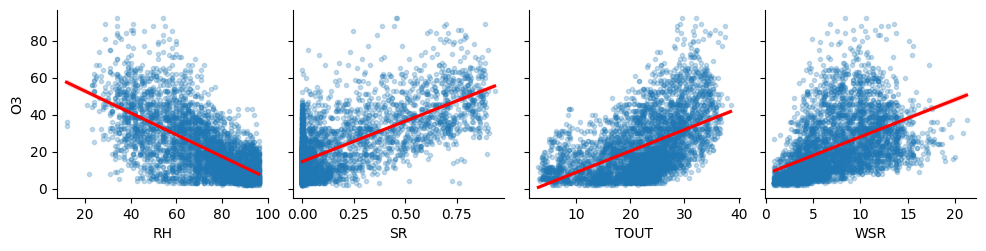

In [7]:
import seaborn as sns

df_pandas = df.toPandas()
sns.pairplot(df_pandas, x_vars=corr_mat_df.loc[(corr_mat_df.index != 'O3') & (abs(corr_mat_df.O3) > 0.45), ['O3']].index.to_list(), y_vars=['O3'], kind ='reg', markers='.', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.25}});

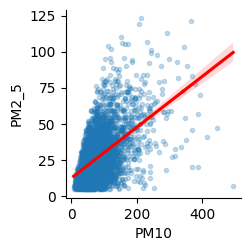

In [8]:
sns.pairplot(df_pandas, x_vars=corr_mat_df.loc[(corr_mat_df.index != 'PM2_5') & (abs(corr_mat_df.PM2_5) > 0.45), ['PM2_5']].index.to_list(), y_vars=['PM2_5'], kind ='reg', markers='.', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.25}});

### Regresion

In [9]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

#Input all the features in one vector column
o3_feature_cols = corr_mat_df.loc[(corr_mat_df.index != 'O3') & (abs(corr_mat_df.O3) > 0.3), ['O3']].index.to_list()
o3_assembler = VectorAssembler(inputCols=o3_feature_cols, outputCol = 'O3_features')
o3_output = o3_assembler.transform(df.na.drop())
#Input vs Output
o3_data = o3_output.select("O3_features", "O3")

#Input all the features in one vector column
p2_5_feature_cols = corr_mat_df.loc[(corr_mat_df.index != 'PM2_5') & (abs(corr_mat_df.PM2_5) > 0.2), ['PM2_5']].index.to_list()
p2_5_assembler = VectorAssembler(inputCols=p2_5_feature_cols, outputCol = 'PM2_5_features')
p2_5_output = p2_5_assembler.transform(df.na.drop())
#Input vs Output
p2_5_data = p2_5_output.select("PM2_5_features", "PM2_5")

In [10]:
print(f'P2.5 um features: {p2_5_feature_cols}')
p2_5_data.show(10)

P2.5 um features: ['CO', 'NO', 'NO2', 'NOX', 'PM10']
+--------------------+-----+
|      PM2_5_features|PM2_5|
+--------------------+-----+
|[2.51,10.2,12.9,2...|   80|
|[2.41,9.2,11.6,20...|   29|
|[2.39,8.1,11.8,19...|    9|
|[2.26,5.3,8.9,14....|   14|
|[2.25,7.2,10.2,17...|    8|
|[2.21,5.8,8.2,14....|    6|
|[2.38,10.0,10.1,2...|   17|
|[2.51,11.5,12.3,2...|   16|
|[2.55,12.0,13.5,2...|   19|
|[2.45,10.5,12.8,2...|   35|
+--------------------+-----+
only showing top 10 rows



In [11]:
print(f'O3 features: {o3_feature_cols}')
o3_data.show(10)

O3 features: ['NO2', 'NOX', 'RH', 'SR', 'TOUT', 'WSR']
+--------------------+---+
|         O3_features| O3|
+--------------------+---+
|[12.9,23.1,96.0,0...| 10|
|[11.6,20.8,96.0,0...|  7|
|[11.8,19.9,96.0,0...|  7|
|[8.9,14.2,96.0,0....|  7|
|[10.2,17.4,96.0,0...|  5|
|[8.2,14.0,96.0,0....|  7|
|[10.1,20.1,96.0,0...| 10|
|[12.3,23.8,95.0,0...| 12|
|[13.5,25.5,94.0,0...| 14|
|[12.8,23.3,93.0,0...| 11|
+--------------------+---+
only showing top 10 rows



##### Separar en entrenamiento y prueba

In [12]:
#Split training and testing data
o3_train_data, o3_test_data = o3_data.randomSplit([0.8,0.2], seed=25)

p2_5_train_data, p2_5_test_data = p2_5_data.randomSplit([0.8,0.2], seed=25)

#### Regresión lineal y GBT de Ozono

In [13]:
regressor = LinearRegression(featuresCol='O3_features', labelCol='O3')
o3_fitted = regressor.fit(o3_train_data)

o3_lr_predictions = o3_fitted.transform(o3_test_data)

evaluator = RegressionEvaluator(labelCol="O3", predictionCol="prediction", metricName="rmse")
o3_rmse = evaluator.evaluate(o3_lr_predictions)
o3_r2 = evaluator.evaluate(o3_lr_predictions, {evaluator.metricName: 'r2'})

print(f'rmse: {o3_rmse}')
print(f'r2: {o3_r2}')

o3_pred_lr = o3_fitted.evaluate(o3_test_data)
o3_pred_lr.predictions.show(10)

rmse: 9.480751480013014
r2: 0.6825442332701455
+--------------------+---+------------------+
|         O3_features| O3|        prediction|
+--------------------+---+------------------+
|[3.0,5.3,82.0,0.0...| 16|17.007163313346748|
|[3.2,5.8,40.0,0.8...| 51|55.116264156923506|
|[3.4,5.6,70.0,0.0...| 38|21.392522535391414|
|[3.5,8.4,60.0,0.6...| 26|    43.81990947489|
|[3.6,8.2,66.0,0.7...| 24|45.292630845418444|
|[3.7,6.3,83.0,0.0...| 14| 15.16173242710174|
|[3.799999952,6.19...| 13|18.291656839947205|
|[3.799999952,7.40...| 38|51.032253372117964|
|[3.8,6.9,42.0,0.4...| 41| 42.61899244775482|
|[3.9,6.1,80.0,0.0...| 14|17.999895438716297|
+--------------------+---+------------------+
only showing top 10 rows



In [14]:
from pyspark.ml.regression import GBTRegressor
o3_rfr = GBTRegressor(featuresCol = 'O3_features', labelCol = 'O3')

#Learn to fit the model from training set
o3_rfr = o3_rfr.fit(o3_test_data)

#To predict the prices on testing set
o3_pred_rfr = o3_rfr.transform(o3_test_data)

o3_gbt_rmse = evaluator.evaluate(o3_pred_rfr, {evaluator.metricName: 'rmse'})
o3_gbt_r2 = evaluator.evaluate(o3_pred_rfr, {evaluator.metricName: 'r2'})

print(f'rmse: {o3_gbt_rmse}')
print(f'r2: {o3_gbt_r2}')
o3_pred_rfr.select('O3_features', 'O3', 'prediction').show(10)

rmse: 4.616226324556151
r2: 0.924738671149147
+--------------------+---+------------------+
|         O3_features| O3|        prediction|
+--------------------+---+------------------+
|[3.0,5.3,82.0,0.0...| 16|14.794735713592408|
|[3.2,5.8,40.0,0.8...| 51| 53.41985491322454|
|[3.4,5.6,70.0,0.0...| 38|32.748050381528856|
|[3.5,8.4,60.0,0.6...| 26|31.571604008510125|
|[3.6,8.2,66.0,0.7...| 24| 29.79588900115711|
|[3.7,6.3,83.0,0.0...| 14|13.829858608442597|
|[3.799999952,6.19...| 13|14.794735713592408|
|[3.799999952,7.40...| 38| 34.55750824404818|
|[3.8,6.9,42.0,0.4...| 41| 47.83889688817845|
|[3.9,6.1,80.0,0.0...| 14|14.794735713592408|
+--------------------+---+------------------+
only showing top 10 rows



GBT presenta una mejor predicción haciendo uso del R2 score y RMSE

#### Regresión lineal, Random Forest y GBT de P2.5 um

In [15]:
regressor = LinearRegression(featuresCol='PM2_5_features', labelCol='PM2_5')
p2_5_fitted = regressor.fit(p2_5_train_data)

p2_5_lr_predictions = p2_5_fitted.transform(p2_5_test_data)

p2_5_rmse = evaluator.evaluate(p2_5_lr_predictions, {evaluator.metricName: 'rmse', evaluator.labelCol: 'PM2_5'})
p2_5_r2 = evaluator.evaluate(p2_5_lr_predictions, {evaluator.metricName: 'r2', evaluator.labelCol: 'PM2_5'})

print(f'rmse: {p2_5_rmse}')
print(f'r2: {p2_5_r2}')

p2_5_pred_lr = p2_5_fitted.evaluate(p2_5_test_data)
p2_5_pred_lr.predictions.show(10)

rmse: 14.41265869351053
r2: 0.19306139607377648
+--------------------+-----+------------------+
|      PM2_5_features|PM2_5|        prediction|
+--------------------+-----+------------------+
|[0.34,3.0,5.1,7.9...|   17|  22.0824352470233|
|[0.36,3.5,5.5,8.7...|   54|30.189482458678754|
|[0.38,3.3,6.6,9.7...|   19|27.999023089849914|
|[0.4,4.0,5.4,9.2,...|   22|29.841076357570095|
|[0.42,4.3,5.5,9.6...|   28| 28.11224544345884|
|[0.43,3.3,6.3,9.4...|    7|27.331560158884933|
|[0.44,4.2,5.9,9.9...|   27|23.790794424084737|
|[0.45,3.5,4.8,8.1...|   39|26.540675675568906|
|[0.45,4.1,6.3,10....|   24|28.053420986305824|
|[0.46,3.3,5.0,8.1...|   46|  31.6451088834052|
+--------------------+-----+------------------+
only showing top 10 rows



In [16]:
from pyspark.ml.regression import RandomForestRegressor
p2_5_rfr = RandomForestRegressor(featuresCol = 'PM2_5_features', labelCol = 'PM2_5')

#Learn to fit the model from training set
p2_5_rfr = p2_5_rfr.fit(p2_5_test_data)

#To predict the prices on testing set
p2_5_pred_rfr = p2_5_rfr.transform(p2_5_test_data)

p2_5_rf_rmse = evaluator.evaluate(p2_5_pred_rfr, {evaluator.metricName: 'rmse', evaluator.labelCol: 'PM2_5'})
p2_5_rf_r2 = evaluator.evaluate(p2_5_pred_rfr, {evaluator.metricName: 'r2', evaluator.labelCol: 'PM2_5'})

print(f'rmse: {p2_5_rf_rmse}')
print(f'r2: {p2_5_rf_r2}')
p2_5_pred_rfr.select('PM2_5_features', 'PM2_5', 'prediction').show(10)

rmse: 12.70087024012147
r2: 0.3733583656435583
+--------------------+-----+------------------+
|      PM2_5_features|PM2_5|        prediction|
+--------------------+-----+------------------+
|[0.34,3.0,5.1,7.9...|   17|21.880097452885646|
|[0.36,3.5,5.5,8.7...|   54|27.681307861218784|
|[0.38,3.3,6.6,9.7...|   19| 23.70676814207583|
|[0.4,4.0,5.4,9.2,...|   22| 27.19069114497869|
|[0.42,4.3,5.5,9.6...|   28|24.123228737344046|
|[0.43,3.3,6.3,9.4...|    7|23.590856410561457|
|[0.44,4.2,5.9,9.9...|   27|23.474041156506807|
|[0.45,3.5,4.8,8.1...|   39|25.870675942505375|
|[0.45,4.1,6.3,10....|   24|24.179534080643393|
|[0.46,3.3,5.0,8.1...|   46|   36.614549163329|
+--------------------+-----+------------------+
only showing top 10 rows



In [17]:
from pyspark.ml.regression import GBTRegressor
p2_5_gtb_rfr = GBTRegressor(featuresCol = 'PM2_5_features', labelCol = 'PM2_5', maxIter=50)

#Learn to fit the model from training set
p2_5_gtb_rfr = p2_5_gtb_rfr.fit(p2_5_test_data)

#To predict the prices on testing set
p2_5_pred_gtb_rfr = p2_5_gtb_rfr.transform(p2_5_test_data)

p2_5_gbt_rmse = evaluator.evaluate(p2_5_pred_gtb_rfr, {evaluator.metricName: 'rmse', evaluator.labelCol: 'PM2_5'})
p2_5_gbt_r2 = evaluator.evaluate(p2_5_pred_gtb_rfr, {evaluator.metricName: 'r2', evaluator.labelCol: 'PM2_5'})

print(f'rmse: {p2_5_gbt_rmse}')
print(f'r2: {p2_5_gbt_r2}')
p2_5_pred_gtb_rfr.select('PM2_5_features', 'PM2_5', 'prediction').show(10)

rmse: 6.377840416294975
r2: 0.8419845381763233
+--------------------+-----+------------------+
|      PM2_5_features|PM2_5|        prediction|
+--------------------+-----+------------------+
|[0.34,3.0,5.1,7.9...|   17|18.871013056325054|
|[0.36,3.5,5.5,8.7...|   54| 50.12380105703661|
|[0.38,3.3,6.6,9.7...|   19|19.937969127432787|
|[0.4,4.0,5.4,9.2,...|   22| 21.76126327858827|
|[0.42,4.3,5.5,9.6...|   28| 25.70828712804347|
|[0.43,3.3,6.3,9.4...|    7|10.243991381777061|
|[0.44,4.2,5.9,9.9...|   27|22.722987713151674|
|[0.45,3.5,4.8,8.1...|   39| 36.94618487134495|
|[0.45,4.1,6.3,10....|   24| 26.76999752889018|
|[0.46,3.3,5.0,8.1...|   46| 44.10790959801305|
+--------------------+-----+------------------+
only showing top 10 rows



GBT muestra una mejor predicción al tener un R2 más cercano a 1 y un RMSE más cercano a 0 (casi la mitad de Random Forest)

### Agrupando por dia y valores estadísticos (Max, min, promedio) para nueva regresión (Forest y GBT) con valores agrupados

In [159]:
from pyspark.sql.functions import regexp_replace, when, lpad, StringType, substring, date_format, to_date

list_features = ['CO', 'NO', 'NO2', 'NOX', 'PM10', 'PRS', 'RAINF', 'RH', 'SR', 'TOUT', 'WSR', 'WDV']
stats = ['MAX', 'AVG', 'MIN']

query_features = ', '.join([f'ROUND({s}({f}), 3) as {s}{f}' for s in stats for f in list_features])

query = f'''SELECT \
Date, \
Month, \
MAX(O3) as MAXO3, \
MAX(`PM2.5`) as MAXP2_5, \
{query_features} \
FROM pollution GROUP BY Date, Month'''

group_df = spark.sql(query)
group_df = group_df.withColumn(
    'Date',
    to_date(
    ### convert "01-abr-15" to 01/04/2015
    when(group_df.Date.rlike(r'([a-z]+)'), regexp_replace(regexp_replace(regexp_replace(group_df.Date, r"([a-z]+)", lpad(group_df.Month, 2, '0')), r"-", "/"), r'(?=\d{2}$)', '20'))
    #.when(group_df.Date.rlike(r'(\d{4})'), regexp_replace(regexp_replace(group_df.Date, r"(\d{4})", substring(group_df.Date, 9, 10)), r'(?=\d{2}$)', '20'))
    .otherwise(group_df.Date),
    "dd/MM/yyy"
    )
).drop('Month').orderBy(['date'], ascending=[1])
group_df.show(10)

+----------+-----+-------+-----+-----+------+------+-------+------+--------+-----+-----+-------+------+------+-----+------+------+------+-------+-------+--------+------+-----+-------+------+-------+-----+-----+------+------+-------+------+--------+-----+-----+-------+------+------+
|      Date|MAXO3|MAXP2_5|MAXCO|MAXNO|MAXNO2|MAXNOX|MAXPM10|MAXPRS|MAXRAINF|MAXRH|MAXSR|MAXTOUT|MAXWSR|MAXWDV|AVGCO| AVGNO|AVGNO2|AVGNOX|AVGPM10| AVGPRS|AVGRAINF| AVGRH|AVGSR|AVGTOUT|AVGWSR| AVGWDV|MINCO|MINNO|MINNO2|MINNOX|MINPM10|MINPRS|MINRAINF|MINRH|MINSR|MINTOUT|MINWSR|MINWDV|
+----------+-----+-------+-----+-----+------+------+-------+------+--------+-----+-----+-------+------+------+-----+------+------+------+-------+-------+--------+------+-----+-------+------+-------+-----+-----+------+------+-------+------+--------+-----+-----+-------+------+------+
|2015-01-01|   14|     80| 2.81| 21.2|  18.6|  39.2|    139| 725.4|    0.02|   96|0.175|   7.43|   8.2|   354|2.473|11.029|12.553|23.582| 43.412|722.45

#### Correlación

In [144]:
group_values_df = group_df.drop('Date')

df_features = group_values_df.select(*group_values_df.columns).dropna()

rdd_table = df_features.rdd.map(lambda row: row[0:])

corr_mat = Statistics.corr(rdd_table, method="pearson")

corr_mat_df = pd.DataFrame(data=corr_mat,index=df_features.columns,columns=df_features.columns)
corr_mat_df

,MAXO3,MAXP2_5,MAXCO,MAXNO,MAXNO2,MAXNOX,MAXPM10,MAXPRS,MAXRAINF,MAXRH,...,MINNO2,MINNOX,MINPM10,MINPRS,MINRAINF,MINRH,MINSR,MINTOUT,MINWSR,MINWDV
MAXO3,1.000000,0.326963,-0.001497,0.080618,0.152120,0.088444,0.349427,-0.368352,-0.067028,-0.271151,...,-0.105776,-0.110215,0.335490,-0.441009,NaN,-0.692892,-0.105130,0.366271,-0.200423,-0.244431
MAXP2_5,0.326963,1.000000,0.354983,0.332878,0.475603,0.372521,0.592989,-0.142621,0.016421,0.155874,...,0.249695,0.228113,0.334112,-0.259208,NaN,-0.187266,-0.154819,-0.013000,-0.396578,-0.261222
MAXCO,-0.001497,0.354983,1.000000,0.813520,0.764168,0.841493,0.585623,0.276210,-0.005403,-0.112493,...,0.598837,0.610609,0.212086,0.211792,NaN,-0.015811,-0.020134,-0.457798,-0.381334,-0.099050
MAXNO,0.080618,0.332878,0.813520,1.000000,0.736790,0.986064,0.716694,0.228093,-0.054833,-0.209628,...,0.577100,0.608885,0.338655,0.150018,NaN,-0.216770,-0.034334,-0.394153,-0.422443,-0.163544
MAXNO2,0.152120,0.475603,0.764168,0.736790,1.000000,0.827907,0.666197,0.307655,-0.013113,-0.156045,...,0.734480,0.715877,0.283156,0.182453,NaN,-0.137060,-0.097722,-0.519839,-0.503147,-0.272073
MAXNOX,0.088444,0.372521,0.841493,0.986064,0.827907,1.000000,0.729263,0.258351,-0.047441,-0.205742,...,0.642303,0.665808,0.340806,0.164040,NaN,-0.203871,-0.050387,-0.447766,-0.462529,-0.196354
MAXPM10,0.349427,0.592989,0.585623,0.716694,0.666197,0.729263,1.000000,-0.047719,0.003626,-0.115771,...,0.400714,0.417860,0.519698,-0.151924,NaN,-0.375684,-0.032529,-0.068194,-0.328958,-0.237339
MAXPRS,-0.368352,-0.142621,0.276210,0.228093,0.307655,0.258351,-0.047719,1.000000,-0.008147,-0.091996,...,0.352816,0.355058,-0.238370,0.906159,NaN,0.163388,-0.055645,-0.742211,-0.143426,-0.070377
MAXRAINF,-0.067028,0.016421,-0.005403,-0.054833,-0.013113,-0.047441,0.003626,-0.008147,1.000000,0.124888,...,0.003087,-0.010392,-0.167511,-0.014601,NaN,0.099766,-0.026777,0.006549,-0.021787,-0.063284
MAXRH,-0.271151,0.155874,-0.112493,-0.209628,-0.156045,-0.205742,-0.115771,-0.091996,0.124888,1.000000,...,-0.056952,-0.077868,-0.153620,-0.139591,NaN,0.541885,-0.001716,-0.132114,-0.181614,0.030677


El minimo de precipitación siempre es 0

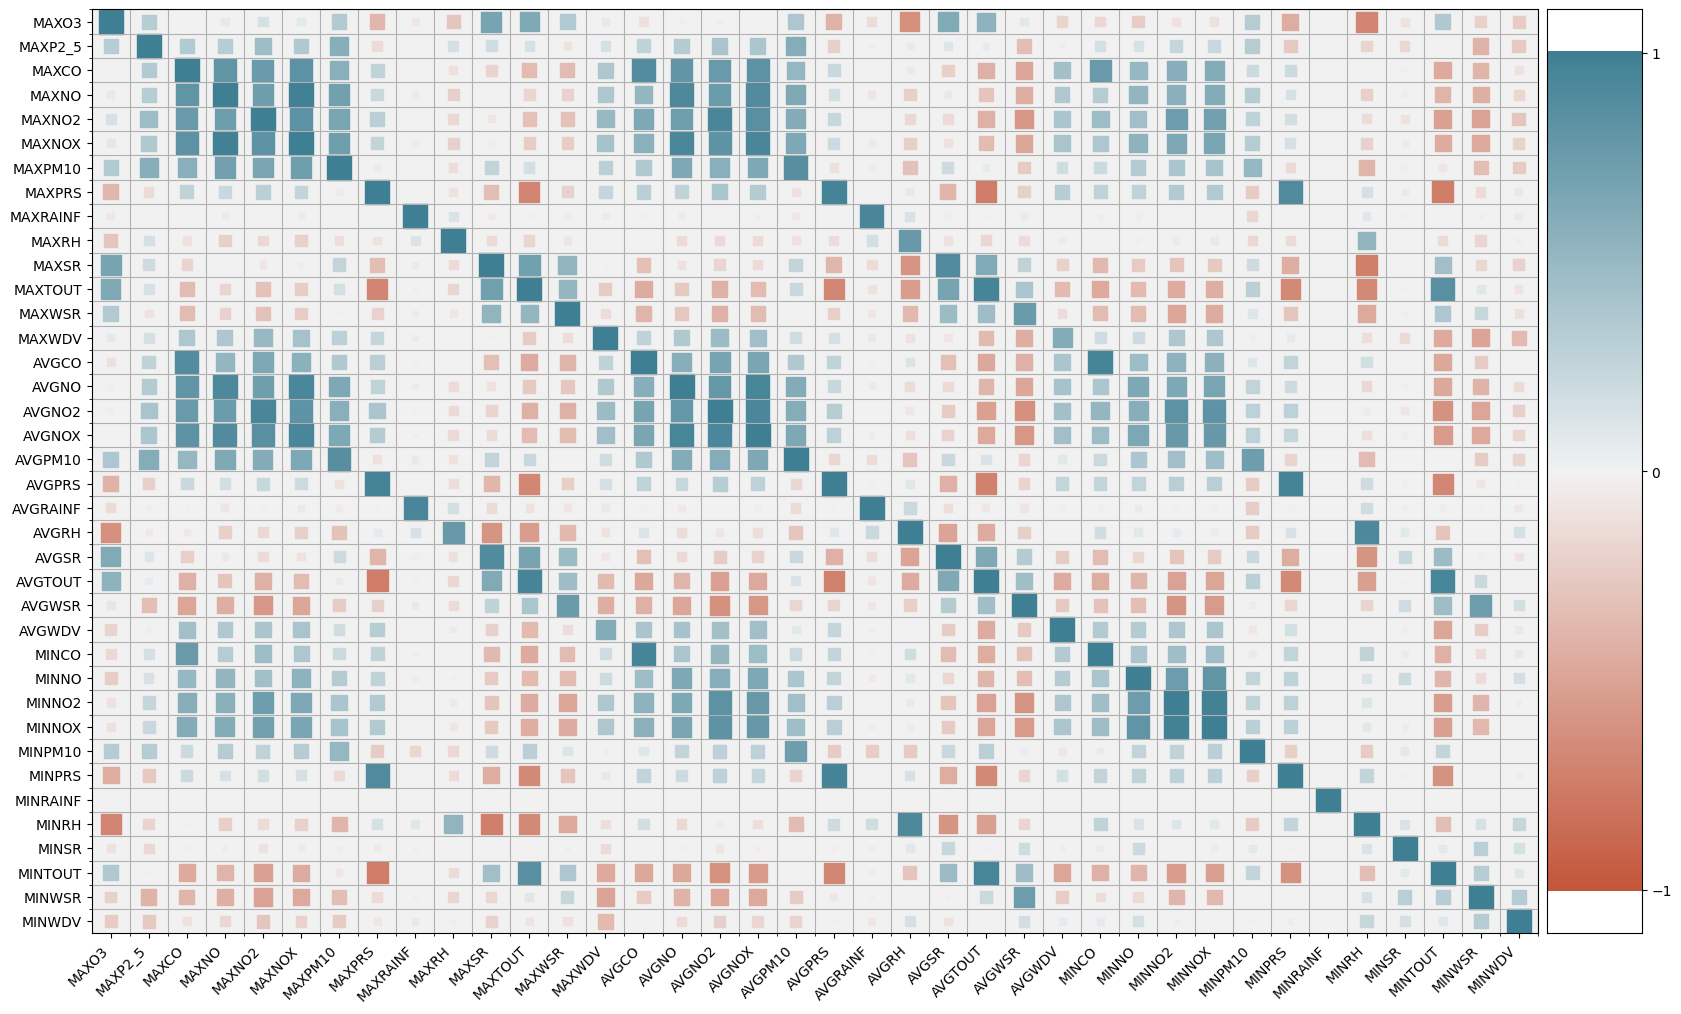

In [148]:
plt.figure(figsize=(20, 12))
corrplot(corr_mat_df ,size_scale=300);

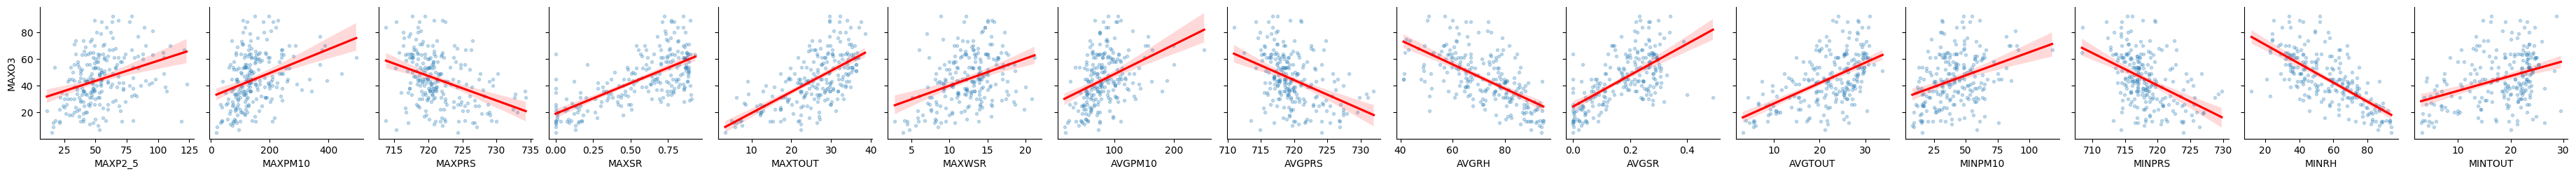

In [175]:
import seaborn as sns
o3_col = 'MAXO3'
df_pandas = group_values_df.toPandas()
sns.pairplot(df_pandas, x_vars=corr_mat_df.loc[(corr_mat_df.index != o3_col) & (abs(corr_mat_df.MAXO3) > 0.3), [o3_col]].index.to_list(), y_vars=[o3_col], kind ='reg', markers='.', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.25}});

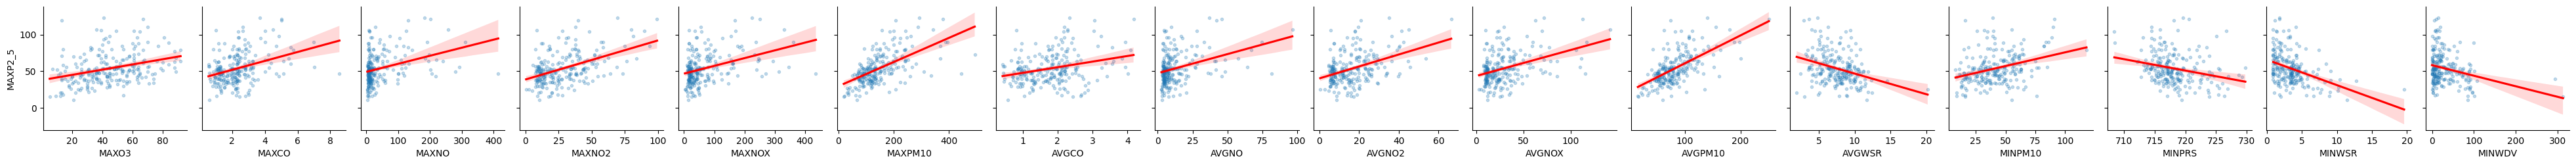

In [176]:
pm_col = 'MAXP2_5'

sns.pairplot(df_pandas, x_vars=corr_mat_df.loc[(corr_mat_df.index != pm_col) & (abs(corr_mat_df.MAXP2_5) > 0.25), [pm_col]].index.to_list(), y_vars=[pm_col], kind ='reg', markers='.', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.25}});

#### Regresion

In [177]:
#Input all the features in one vector column
o3_feature_cols = corr_mat_df.loc[(corr_mat_df.index != o3_col) & (abs(corr_mat_df.MAXO3) > 0.3), [o3_col]].index.to_list()
o3_assembler = VectorAssembler(inputCols=o3_feature_cols, outputCol = 'O3_features')
o3_output = o3_assembler.transform(group_df.na.drop())
#Input vs Output
o3_data = o3_output.select("O3_features", o3_col)

#Input all the features in one vector column
p2_5_feature_cols = corr_mat_df.loc[(corr_mat_df.index != pm_col) & (abs(corr_mat_df.MAXP2_5) > 0.25), [pm_col]].index.to_list()
p2_5_assembler = VectorAssembler(inputCols=p2_5_feature_cols, outputCol = 'PM2_5_features')
p2_5_output = p2_5_assembler.transform(group_df.na.drop())
#Input vs Output
p2_5_data = p2_5_output.select("PM2_5_features", pm_col)

In [178]:
#Split training and testing data
o3_train_data, o3_test_data = o3_data.randomSplit([0.8,0.2], seed=25)

p2_5_train_data, p2_5_test_data = p2_5_data.randomSplit([0.8,0.2], seed=25)

##### O3

In [179]:
regressor = LinearRegression(featuresCol='O3_features', labelCol=o3_col)
o3_fitted = regressor.fit(o3_train_data)

o3_lr_predictions = o3_fitted.transform(o3_test_data)

o3_rmse = evaluator.evaluate(o3_lr_predictions, {evaluator.metricName: 'rmse', evaluator.labelCol: o3_col})
o3_r2 = evaluator.evaluate(o3_lr_predictions, {evaluator.metricName: 'r2', evaluator.labelCol: o3_col})

print(f'rmse: {o3_rmse}')
print(f'r2: {o3_r2}')

o3_pred_lr = o3_fitted.evaluate(o3_test_data)
o3_pred_lr.predictions.show(10)

rmse: 10.52761117346971
r2: 0.6304962499804116
+--------------------+-----+------------------+
|         O3_features|MAXO3|        prediction|
+--------------------+-----+------------------+
|[25.0,207.0,719.9...|   30|31.718929054498176|
|[29.0,89.0,719.7,...|   18|25.098347879079313|
|[32.0,145.0,721.0...|   50| 59.74556958298797|
|[35.0,125.0,721.1...|   37| 48.60918763399451|
|[37.0,125.0,724.5...|   31|25.399473797849282|
|[38.0,75.0,721.0,...|   13|19.824021151375746|
|[40.0,57.0,720.1,...|   15|25.309133266684796|
|[40.0,99.0,730.0,...|   13|14.550302250558559|
|[40.0,113.0,727.8...|   19| 36.15147091654683|
|[41.0,135.0,720.2...|   36| 40.11780888023429|
+--------------------+-----+------------------+
only showing top 10 rows



In [180]:
o3_rfr = GBTRegressor(featuresCol = 'O3_features', labelCol = o3_col)

#Learn to fit the model from training set
o3_rfr = o3_rfr.fit(o3_test_data)

#To predict the prices on testing set
o3_pred_rfr = o3_rfr.transform(o3_test_data)

o3_gbt_rmse = evaluator.evaluate(o3_pred_rfr, {evaluator.metricName: 'rmse', evaluator.labelCol: o3_col})
o3_gbt_r2 = evaluator.evaluate(o3_pred_rfr, {evaluator.metricName: 'r2', evaluator.labelCol: o3_col})

print(f'rmse: {o3_gbt_rmse}')
print(f'r2: {o3_gbt_r2}')
o3_pred_rfr.select('O3_features', o3_col, 'prediction').show(10)

rmse: 0.051267988625443066
r2: 0.9999912370217006
+--------------------+-----+------------------+
|         O3_features|MAXO3|        prediction|
+--------------------+-----+------------------+
|[25.0,207.0,719.9...|   30| 29.98621567520361|
|[29.0,89.0,719.7,...|   18|17.921714600113965|
|[32.0,145.0,721.0...|   50| 49.99822386594153|
|[35.0,125.0,721.1...|   37| 37.03708257495949|
|[37.0,125.0,724.5...|   31|31.002477877366733|
|[38.0,75.0,721.0,...|   13| 13.03076858563238|
|[40.0,57.0,720.1,...|   15| 15.06956774832391|
|[40.0,99.0,730.0,...|   13| 12.99686069063624|
|[40.0,113.0,727.8...|   19|18.911469846897212|
|[41.0,135.0,720.2...|   36| 36.00122727277845|
+--------------------+-----+------------------+
only showing top 10 rows



##### PM2.5

In [181]:
from pyspark.ml.regression import RandomForestRegressor
p2_5_rfr = RandomForestRegressor(featuresCol = 'PM2_5_features', labelCol = pm_col)

#Learn to fit the model from training set
p2_5_rfr = p2_5_rfr.fit(p2_5_test_data)

#To predict the prices on testing set
p2_5_pred_rfr = p2_5_rfr.transform(p2_5_test_data)

p2_5_rf_rmse = evaluator.evaluate(p2_5_pred_rfr, {evaluator.metricName: 'rmse', evaluator.labelCol: pm_col})
p2_5_rf_r2 = evaluator.evaluate(p2_5_pred_rfr, {evaluator.metricName: 'r2', evaluator.labelCol: pm_col})

print(f'rmse: {p2_5_rf_rmse}')
print(f'r2: {p2_5_rf_r2}')
p2_5_pred_rfr.select('PM2_5_features', pm_col, 'prediction').show(10)

rmse: 5.296424957127869
r2: 0.8541905538906251
+--------------------+-------+------------------+
|      PM2_5_features|MAXP2_5|        prediction|
+--------------------+-------+------------------+
|[14.0,1.83,4.2,5....|     58| 49.24950980392157|
|[17.0,2.28,7.4,8....|     37|45.703676470588235|
|[20.0,2.28,22.5,2...|     33| 38.45583333333334|
|[25.0,1.99,6.1,24...|     41| 41.30685107376284|
|[26.0,2.31,19.4,3...|     27|           32.2875|
|[28.0,0.87,8.8,7....|     38|42.081652661064425|
|[30.0,2.33,9.5,16...|     50| 48.84583916900094|
|[31.0,2.44,55.2,4...|     37|            39.925|
|[31.0,2.79,22.0,2...|     52| 46.98416666666667|
|[33.0,1.16,10.8,1...|     43|46.448413122824896|
+--------------------+-------+------------------+
only showing top 10 rows



In [182]:
from pyspark.ml.regression import GBTRegressor
p2_5_gtb_rfr = GBTRegressor(featuresCol = 'PM2_5_features', labelCol = pm_col, maxIter=50)

#Learn to fit the model from training set
p2_5_gtb_rfr = p2_5_gtb_rfr.fit(p2_5_test_data)

#To predict the prices on testing set
p2_5_pred_gtb_rfr = p2_5_gtb_rfr.transform(p2_5_test_data)

p2_5_gbt_rmse = evaluator.evaluate(p2_5_pred_gtb_rfr, {evaluator.metricName: 'rmse', evaluator.labelCol: pm_col})
p2_5_gbt_r2 = evaluator.evaluate(p2_5_pred_gtb_rfr, {evaluator.metricName: 'r2', evaluator.labelCol: pm_col})

print(f'rmse: {p2_5_gbt_rmse}')
print(f'r2: {p2_5_gbt_r2}')
p2_5_pred_gtb_rfr.select('PM2_5_features', pm_col, 'prediction').show(10)

rmse: 6.493883476113532e-05
r2: 0.9999999999780805
+--------------------+-------+------------------+
|      PM2_5_features|MAXP2_5|        prediction|
+--------------------+-------+------------------+
|[14.0,1.83,4.2,5....|     58|57.999938841196915|
|[17.0,2.28,7.4,8....|     37| 37.00001732805967|
|[20.0,2.28,22.5,2...|     33| 32.99994658589088|
|[25.0,1.99,6.1,24...|     41| 40.99994785284024|
|[26.0,2.31,19.4,3...|     27|26.999919571685076|
|[28.0,0.87,8.8,7....|     38| 38.00006520450713|
|[30.0,2.33,9.5,16...|     50|49.999981795760206|
|[31.0,2.44,55.2,4...|     37| 37.00001766508954|
|[31.0,2.79,22.0,2...|     52|52.000087934736236|
|[33.0,1.16,10.8,1...|     43| 43.00001678658073|
+--------------------+-------+------------------+
only showing top 10 rows



GBT Mejoro al grado que es capaz de predecir al 99% el nivel de particulas de 2.5um y Ozono en el aire

### Conclusión

Agrupar y realizar análisis de manera estadística (máximo, minimos y promedios) en un día mejoro el modelo a tal grado que puede predecir con mayor exactitud los nieveles de contaminación por O3 y aprticulas de 2.5um en el aire